In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


###Data Preparation

In [3]:
import pandas as pd

# Load the dataset
fashion_df = pd.read_csv('/content/gdrive/MyDrive/Dataset/fashion.csv')

# Preview the dataset
print(fashion_df.head())


   ProductId Gender Category SubCategory ProductType Colour   Usage  \
0      42419  Girls  Apparel     Topwear        Tops  White  Casual   
1      34009  Girls  Apparel     Topwear        Tops  Black  Casual   
2      40143  Girls  Apparel     Topwear        Tops   Blue  Casual   
3      23623  Girls  Apparel     Topwear        Tops   Pink  Casual   
4      47154  Girls  Apparel  Bottomwear      Capris  Black  Casual   

                                  ProductTitle      Image  \
0           Gini and Jony Girls Knit White Top  42419.jpg   
1                Gini and Jony Girls Black Top  34009.jpg   
2  Gini and Jony Girls Pretty Blossom Blue Top  40143.jpg   
3   Doodle Kids Girls Pink I love Shopping Top  23623.jpg   
4             Gini and Jony Girls Black Capris  47154.jpg   

                                            ImageURL  
0  http://assets.myntassets.com/v1/images/style/p...  
1  http://assets.myntassets.com/v1/images/style/p...  
2  http://assets.myntassets.com/v1/images

In [4]:
# Update the ImageURL column to point to the correct paths
fashion_df['ImageURL'] = '/content/gdrive/MyDrive/Dataset/images/' + fashion_df['Image']

# Verify the updated paths
print(fashion_df['ImageURL'].head())


0    /content/gdrive/MyDrive/Dataset/images/42419.jpg
1    /content/gdrive/MyDrive/Dataset/images/34009.jpg
2    /content/gdrive/MyDrive/Dataset/images/40143.jpg
3    /content/gdrive/MyDrive/Dataset/images/23623.jpg
4    /content/gdrive/MyDrive/Dataset/images/47154.jpg
Name: ImageURL, dtype: object


In [ ]:
!ls '/content/gdrive/MyDrive/Dataset/images/'


ls: cannot access '/content/gdrive/MyDrive/Dataset/images/': No such file or directory


In [ ]:
import requests
import os
import time

# Specify the folder on your Google Drive where you want to save the images
save_folder = '/content/gdrive/MyDrive/Dataset/images/'

# Create the directory if it doesn't exist
os.makedirs(save_folder, exist_ok=True)

# Load the original CSV file (before any modifications to the ImageURL column)
original_fashion_df = pd.read_csv('/content/gdrive/MyDrive/Dataset/fashion.csv')

# Track the number of downloaded and skipped images
downloaded_count = 0
skipped_count = 0

# Download and save all images
for idx, row in original_fashion_df.iterrows():
    img_url = row['ImageURL']
    img_name = row['Image']
    img_path = os.path.join(save_folder, img_name)

    # Check if the image file already exists
    if os.path.exists(img_path):
        skipped_count += 1
        continue

    # Attempt to download the image with retries
    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = requests.get(img_url)
            with open(img_path, 'wb') as file:
                file.write(response.content)
            downloaded_count += 1
            break
        except requests.ConnectionError:
            print(f"Connection error for {img_url}. Retrying...")
            time.sleep(5) # Wait for 5 seconds before retrying
    else:
        print(f"Failed to download {img_url} after {max_retries} attempts.")

# Report the results
print(f"Downloaded {downloaded_count} new images to {save_folder}")
print(f"Skipped {skipped_count} images that already exist")


Downloaded 533 new images to /content/gdrive/MyDrive/Dataset/images/
Skipped 2373 images that already exist


In [ ]:
import os

# Specify the folder on your Google Drive where the images are saved
image_folder = '/content/gdrive/MyDrive/Dataset/images/'

# List all files in the folder
image_files = os.listdir(image_folder)

# Count the number of image files (assuming they have .jpg extension)
image_count = sum([file.endswith('.jpg') for file in image_files])

print(f"There are {image_count} images in the folder {image_folder}")


There are 2906 images in the folder /content/gdrive/MyDrive/Dataset/images/


###Image Analysis

In [4]:
# Modifying the code for image preprocessing and feature extraction to make it more efficient

# Defining a function to extract features from images using MobileNet
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

def extract_features(image_paths, batch_size=32):
    # Load pre-trained MobileNet model
    mobilenet_model = MobileNet(weights='imagenet', include_top=False)

    features_list = []

    # Process images in batches
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        images = [load_img(image_path, target_size=(224, 224)) for image_path in batch_paths]
        images_array = np.array([img_to_array(img) for img in images])
        images_array = preprocess_input(images_array)

        # Predict features using MobileNet
        batch_features = mobilenet_model.predict(images_array)
        batch_features_flatten = [feature.reshape(-1) for feature in batch_features]
        features_list.extend(batch_features_flatten)

    return np.array(features_list)

# Example usage (assuming fashion_df['ImageURL'] contains the image paths)
X = extract_features(fashion_df['ImageURL'])


1/1 [==============================] - 1s 1s/step


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def encode_labels(column):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(fashion_df[column])
    return to_categorical(labels), label_encoder

y_category, label_encoder_category = encode_labels('Category')
y_subcategory, label_encoder_subcategory = encode_labels('SubCategory')
y_color, label_encoder_color = encode_labels('Colour')
y_product_type, label_encoder_product_type = encode_labels('ProductType')
y_usage, label_encoder_usage = encode_labels('Usage')

def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data
X_train, X_test, y_train_category, y_test_category = split_data(X, y_category)
_, _, y_train_subcategory, y_test_subcategory = split_data(X, y_subcategory)
_, _, y_train_color, y_test_color = split_data(X, y_color)
_, _, y_train_product_type, y_test_product_type = split_data(X, y_product_type)
_, _, y_train_usage, y_test_usage = split_data(X, y_usage)



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_model(y):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3)) # Dropout layer to prevent overfitting
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3)) # Dropout layer to prevent overfitting
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_save(model, y_train, model_name):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
    model.save(os.path.join('models', model_name))

# Training
train_and_save(create_model(y_category), y_train_category, 'model_category.h5')




Epoch 1/50
66/66 [==============================] - 4s 17ms/step - loss: 0.3311 - accuracy: 0.9823 - val_loss: 6.4907e-06 - val_accuracy: 1.0000
Epoch 2/50
66/66 [==============================] - 1s 13ms/step - loss: 0.0354 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
66/66 [==============================] - 1s 13ms/step - loss: 0.6646 - accuracy: 0.9952 - val_loss: 0.1380 - val_accuracy: 0.9957
Epoch 4/50
66/66 [==============================] - 1s 12ms/step - loss: 4.2307e-04 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
66/66 [==============================] - 1s 13ms/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 

In [ ]:
train_and_save(create_model(y_subcategory), y_train_subcategory, 'model_subcategory.h5')
train_and_save(create_model(y_color), y_train_color, 'model_color.h5')

Epoch 1/50
66/66 [==============================] - 2s 14ms/step - loss: 4.0327 - accuracy: 0.8250 - val_loss: 0.6122 - val_accuracy: 0.9227
Epoch 2/50
66/66 [==============================] - 1s 11ms/step - loss: 0.8320 - accuracy: 0.9307 - val_loss: 0.6058 - val_accuracy: 0.9399
Epoch 3/50
66/66 [==============================] - 1s 10ms/step - loss: 0.4639 - accuracy: 0.9474 - val_loss: 0.2631 - val_accuracy: 0.9700
Epoch 4/50
66/66 [==============================] - 1s 10ms/step - loss: 0.3148 - accuracy: 0.9608 - val_loss: 0.3606 - val_accuracy: 0.9356
Epoch 5/50
66/66 [==============================] - 1s 11ms/step - loss: 0.2382 - accuracy: 0.9627 - val_loss: 0.2534 - val_accuracy: 0.9785
Epoch 6/50
66/66 [==============================] - 1s 12ms/step - loss: 0.2207 - accuracy: 0.9699 - val_loss: 0.4141 - val_accuracy: 0.9528
Epoch 7/50
66/66 [==============================] - 1s 12ms/step - loss: 0.1261 - accuracy: 0.9804 - val_loss: 0.4920 - val_accuracy: 0.9528
Epoch 8/50
66

In [ ]:
train_and_save(create_model(y_product_type), y_train_product_type, 'model_product_type.h5')
train_and_save(create_model(y_usage), y_train_usage, 'model_usage.h5')

Epoch 1/50
66/66 [==============================] - 2s 14ms/step - loss: 6.8004 - accuracy: 0.4821 - val_loss: 0.9353 - val_accuracy: 0.7296
Epoch 2/50
66/66 [==============================] - 1s 11ms/step - loss: 1.2654 - accuracy: 0.6729 - val_loss: 0.9042 - val_accuracy: 0.7682
Epoch 3/50
66/66 [==============================] - 1s 11ms/step - loss: 1.0003 - accuracy: 0.7360 - val_loss: 0.7915 - val_accuracy: 0.7854
Epoch 4/50
66/66 [==============================] - 1s 11ms/step - loss: 0.9258 - accuracy: 0.7575 - val_loss: 0.8146 - val_accuracy: 0.8112
Epoch 5/50
66/66 [==============================] - 1s 10ms/step - loss: 0.8989 - accuracy: 0.7657 - val_loss: 0.8354 - val_accuracy: 0.8240
Epoch 6/50
66/66 [==============================] - 1s 11ms/step - loss: 0.7908 - accuracy: 0.8058 - val_loss: 0.7796 - val_accuracy: 0.8155
Epoch 7/50
66/66 [==============================] - 1s 10ms/step - loss: 0.6951 - accuracy: 0.8321 - val_loss: 0.7880 - val_accuracy: 0.8283
Epoch 8/50
66

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

mobilenet_model = MobileNet(weights='imagenet', include_top=False)

def get_image_features(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features = mobilenet_model.predict(image)
    return features.reshape(-1)  # Flatten the features


In [ ]:
from tensorflow.keras.models import load_model
import glob
import os
def load_all_models():
    models = {}
    models['category'] = load_model('models/model_category.h5')
    models['subcategory'] = load_model('models/model_subcategory.h5')
    models['color'] = load_model('models/model_color.h5')
    models['product_type'] = load_model('models/model_product_type.h5')
    models['usage'] = load_model('models/model_usage.h5')
    return models

import numpy as np

# ...

def predict_details(image_path, models):
    features = get_image_features(image_path)
    features = features.reshape(1, -1)

    details = {}
    details['Category'] = label_encoder_category.inverse_transform([np.argmax(models['category'].predict(features))])[0]
    details['SubCategory'] = label_encoder_subcategory.inverse_transform([np.argmax(models['subcategory'].predict(features))])[0]
    details['Color'] = label_encoder_color.inverse_transform([np.argmax(models['color'].predict(features))])[0]
    details['ProductType'] = label_encoder_product_type.inverse_transform([np.argmax(models['product_type'].predict(features))])[0]
    details['Usage'] = label_encoder_usage.inverse_transform([np.argmax(models['usage'].predict(features))])[0]

    return details


models = load_all_models()
test_images_folder = '/content/gdrive/MyDrive/Dataset/test_images/test_images/'
for image_path in glob.glob(os.path.join(test_images_folder, '*.jpg')):
    details = predict_details(image_path, models)
    print(f"Details for {os.path.basename(image_path)}:")
    for key, value in details.items():
        print(f"{key}: {value}")
    print()


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 58ms/step
Details for 1.jpg:
Category: Apparel
SubCategory: Topwear
Color: Yellow
ProductType: Tshirts
Usage: Casual

1/1 [==============================] - 0s 21ms/step
Details for 2.jpg:
Category: Apparel
SubCategory: Bottomwear
Color: White
ProductType: Tshirts
Usage: Casual

1/1 [==============================] - 0s 19ms/step
Details for 3.jpg:
Category: Footwear
SubCategory: Shoes
Color: Black
ProductType: Sports Shoes
Usage: Casual

1/1 [==============================] - 0s 20ms/step
Details for 5.jpg:
Category: Apparel
SubCategory: Topwear
Color: Blue
ProductType: Dresses
Usage: Casual



###Key Detail Prediction: I tried multiple models


In [ ]:
import shutil
import os

source_folder = '/content/models/'
destination_folder = '/content/gdrive/MyDrive/Dataset'

# Make sure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# List all files with .h5 extension in the source folder
model_files = [f for f in os.listdir(source_folder) if f.endswith('.h5')]

# Copy each file to the destination folder
for model_file in model_files:
    source_path = os.path.join(source_folder, model_file)
    destination_path = os.path.join(destination_folder, model_file)
    shutil.copy(source_path, destination_path)

print("Models copied successfully!")


Models copied successfully!


In [ ]:
models = load_all_models()

In [ ]:
from sklearn.metrics import pairwise_distances

def get_similar_products_cnn(image_path, num_results):
    # Get the features for the input image using your existing method
    query_features = extract_features([image_path])

    # Compute pairwise distances between the query and all other feature vectors
    pairwise_dist = pairwise_distances(X, query_features)

    # Get the indices of the top similar products
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]

    # Get the details of the recommended products from your DataFrame (replace with your DataFrame name)
    recommended_products = fashion_df.loc[indices]

    return recommended_products



1/1 [==============================] - 0s 430ms/step
Recommendations for /content/gdrive/MyDrive/Dataset/test_images/test_images/1.jpg:
Product ID: 37630, Title: Madagascar3 Girls Soft Red Printed T-Shirt


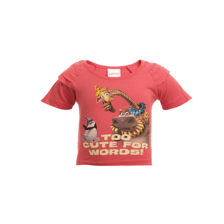

Product ID: 4219, Title: Disney Kids Boy's Orange Colour Blast Kidswear


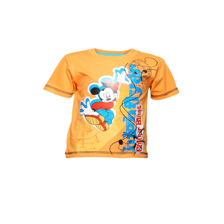

Product ID: 22586, Title: Nike Kids Boys Blue T-shirt


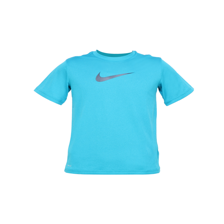

Product ID: 4209, Title: Disney Kids Boy's Green Mickey On Skates Kidswear


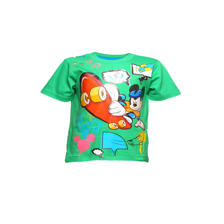

Product ID: 22587, Title: Nike Kids Boys Purple T-shirt


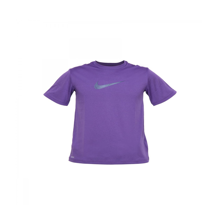


1/1 [==============================] - 0s 433ms/step
Recommendations for /content/gdrive/MyDrive/Dataset/test_images/test_images/2.jpg:
Product ID: 2719, Title: Disney Kids Boy's Tiger Print Denim Pants


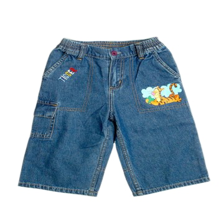

Product ID: 2720, Title: Disney Kids Boy's Mickey Mouse Print Pants


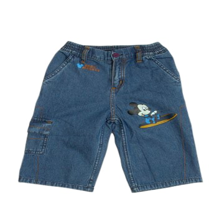

Product ID: 13258, Title: Gini and Jony Girls Purple Shorts


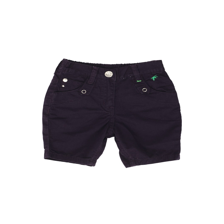

Product ID: 38900, Title: Allen Solly Kids Girls Poplin Yellow Capris


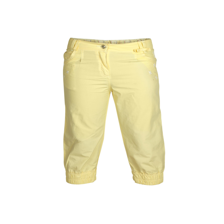

Product ID: 47151, Title: Gini and Jony Kids Girls Black Capris


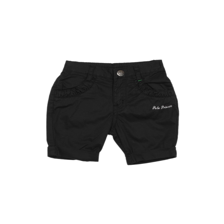


1/1 [==============================] - 1s 670ms/step
Recommendations for /content/gdrive/MyDrive/Dataset/test_images/test_images/3.jpg:
Product ID: 37538, Title: Madagascar 3 Infant Boys Blue Booties


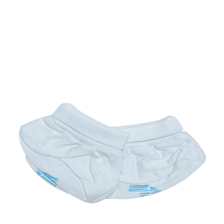

Product ID: 39896, Title: ADIDAS Women Blue Adi Light Sports Shoes


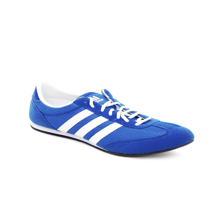

Product ID: 15740, Title: Nike Women Air Relentless Grey Sports Shoes


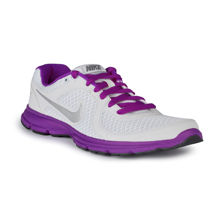

Product ID: 37537, Title: Madagascar 3 Infant Boys Yellow Booties


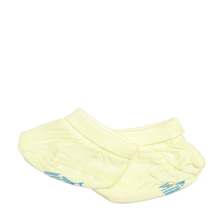

Product ID: 37549, Title: Madagascar 3 Infants Girls Pink Booties


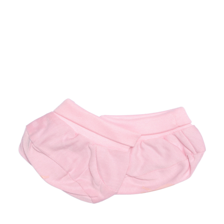


1/1 [==============================] - 1s 639ms/step
Recommendations for /content/gdrive/MyDrive/Dataset/test_images/test_images/5.jpg:
Product ID: 24992, Title: United Colors of Benetton Kids Girls Pink Shorts


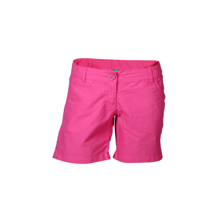

Product ID: 32647, Title: Nike Kids Boys Contemporary Athlete Blue T-shirt


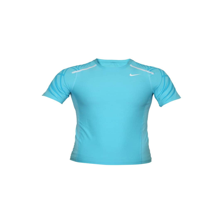

Product ID: 39320, Title: Gini and Jony Boys Navy Blue Shorts


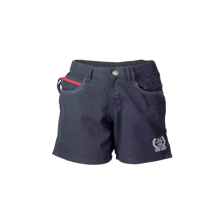

Product ID: 24993, Title: United Colors of Benetton Kids Girls Navy Blue Shorts


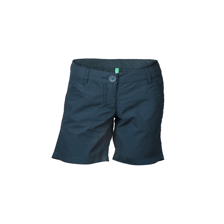

Product ID: 40995, Title: Gini and Jony Girls Woven Pink Pedal Pusher


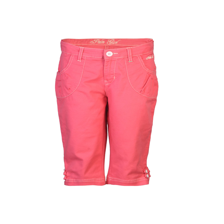

In [ ]:
from PIL import Image as PILImage
from IPython.display import display

test_images_folder = '/content/gdrive/MyDrive/Dataset/test_images/test_images'
image_paths = glob.glob(test_images_folder + '/*.jpg')  # Adjust the file extension if necessary
#image_paths = '/content/gdrive/MyDrive/Dataset/test_images/test_images/3.jpg'
num_results = 5

for image_path in image_paths:
    recommended_products = get_similar_products_cnn(image_path, num_results)

    print(f"Recommendations for {image_path}:")
    for idx, product in recommended_products.iterrows():
        print(f"Product ID: {product['ProductId']}, Title: {product['ProductTitle']}")
        img = PILImage.open(product['ImageURL'])
        img = img.resize((224, 224))
        display(img)
    print()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Prepare the product information data
product_titles = fashion_df['ProductTitle'].tolist()

# Text preprocessing and tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(product_titles)
total_words = len(tokenizer.word_index) + 1

# Convert text to sequences
input_sequences = []
for line in product_titles:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

# Create predictors and labels
X, y = input_sequences[:, :-1], input_sequences[:, -1]

# One-hot encode the labels
y = to_categorical(y, num_classes=total_words)

# Model architecture
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_length-1))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=100, verbose=1)

# Generate product descriptions
def generate_product_description(seed_text, num_words):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted_token = np.argmax(model.predict(token_list), axis=-1)
        output_word = tokenizer.index_word[predicted_token[0]]
        seed_text += " " + output_word
    return seed_text

# Generate description for a given seed text
seed_text = "Stylish Women's Dress"
generated_description = generate_product_description(seed_text, num_words=20)
print("Generated Description:", generated_description)

Epoch 1/100
480/480 [==============================] - 12s 19ms/step - loss: 4.3904 - accuracy: 0.1913
Epoch 2/100
480/480 [==============================] - 3s 7ms/step - loss: 3.0827 - accuracy: 0.3805
Epoch 3/100
480/480 [==============================] - 4s 8ms/step - loss: 2.6036 - accuracy: 0.4384
Epoch 4/100
480/480 [==============================] - 4s 8ms/step - loss: 2.3313 - accuracy: 0.4734
Epoch 5/100
480/480 [==============================] - 3s 7ms/step - loss: 2.1385 - accuracy: 0.4928
Epoch 6/100
480/480 [==============================] - 3s 6ms/step - loss: 1.9790 - accuracy: 0.5162
Epoch 7/100
480/480 [==============================] - 3s 6ms/step - loss: 1.8459 - accuracy: 0.5326
Epoch 8/100
480/480 [==============================] - 3s 6ms/step - loss: 1.7322 - accuracy: 0.5520
Epoch 9/100
480/480 [==============================] - 3s 7ms/step - loss: 1.6305 - accuracy: 0.5623
Epoch 10/100
480/480 [==============================] - 3s 5ms/step - loss: 1.5425 - accu

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Prepare the product information data
product_titles = fashion_df['ProductTitle'].tolist()

# Text preprocessing and tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(product_titles)
total_words = len(tokenizer.word_index) + 1

# Convert text to sequences
input_sequences = []
for line in product_titles:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

# Create predictors and labels
X, y = input_sequences[:, :-1], input_sequences[:, -1]

# One-hot encode the labels
y = to_categorical(y, num_classes=total_words)

# Model architecture
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_length-1))
model.add(Bidirectional(LSTM(200, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=100, verbose=1)

# Generate product descriptions
def generate_product_description(seed_text, num_words):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted_token = np.argmax(model.predict(token_list), axis=-1)
        output_word = tokenizer.index_word[predicted_token[0]]
        seed_text += " " + output_word
    return seed_text

# Generate description for a given seed text
seed_text = "Stylish Women's Dress"
generated_description = generate_product_description(seed_text, num_words=20)
print("Generated Description:", generated_description)

In [1]:
import pandas as pd
import numpy as np
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer, TrainingArguments, Trainer
import tensorflow as tf

# Load the dataset


# Load the pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
model = TFGPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Extract image features using your preferred method
from tensorflow.keras.preprocessing import image


# Example: Extract image features for each image in the dataset
image_features = []
for img_path in fashion_df['ImageURL']:
    features = X
    image_features.append(features)
image_features = np.array(image_features)

# Define a custom dataset class
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, descriptions, image_features, tokenizer, max_length):
        self.descriptions = descriptions
        self.image_features = X
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        text = self.descriptions[idx]
        image = self.image_features[idx]
        encoded_text = self.tokenizer.encode(text, max_length=self.max_length, padding='max_length', truncation=True)
        return {"input_ids": encoded_text, "image_features": image}

# Define your dataset and dataloader
batch_size = 4
max_length = 100
dataset = CustomDataset(fashion_df['ProductTitle'], image_features, tokenizer, max_length)
dataloader = tf.data.DataLoader(dataset, batch_size=batch_size)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./output",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=batch_size,
    save_steps=500,
)

# Initialize Trainer and start fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataloader,
)

trainer.train()


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


NameError: ignored

In [5]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.6 MB/s eta 0:00:00


In [10]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel
from torch.nn.utils.rnn import pad_sequence
from PIL import Image

# Function to extract image features
def extract_image_features(image_path):
    model = models.resnet18(pretrained=True)
    model.eval()

    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        features = model(input_batch)

    return features.squeeze()

class FashionDataset(Dataset):
    def __init__(self, csv_file, image_folder):
        self.data_frame = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        row = self.data_frame.iloc[idx]
        input_text = ' '.join([str(row['Gender']), str(row['Category']), str(row['SubCategory']), str(row['ProductType']), str(row['Colour']), str(row['Usage'])])
        description = str(row['ProductTitle'])

        input_ids = self.tokenizer.encode(input_text, return_tensors="pt", max_length=50, truncation=True).squeeze()
        target_ids = self.tokenizer.encode(description, return_tensors="pt", max_length=50, truncation=True).squeeze()

        image_path = self.image_folder + '/' + str(row['Image'])  # Corrected column name and path
        image_features = extract_image_features(image_path)

        return {'input_ids': input_ids, 'target_ids': target_ids, 'image_features': image_features}

# Specify the path to the image folder
image_folder_path = '/content/gdrive/MyDrive/Dataset/images'

train_dataset = FashionDataset(csv_file='/content/gdrive/MyDrive/Dataset/fashion.csv', image_folder=image_folder_path)




In [13]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    target_ids = [item['target_ids'] for item in batch]
    image_features = torch.stack([item['image_features'] for item in batch])

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    target_ids = pad_sequence(target_ids, batch_first=True, padding_value=0)

    return {'input_ids': input_ids, 'target_ids': target_ids, 'image_features': image_features}

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    target_ids = [item['target_ids'] for item in batch]
    image_features = torch.stack([item['image_features'] for item in batch])

    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    target_ids = pad_sequence(target_ids, batch_first=True, padding_value=0)

    return {'input_ids': input_ids, 'target_ids': target_ids, 'image_features': image_features}
class DescriptionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = BertModel.from_pretrained('bert-base-uncased')
        self.image_feature_processor = nn.Sequential(
            nn.Linear(1000, 768),
            nn.ReLU()
        )
        self.target_embedding = nn.Embedding(self.encoder.config.vocab_size, 768)
        self.decoder = nn.GRU(768, 768, batch_first=True)
        self.fc = nn.Linear(768, self.encoder.config.vocab_size)

    def forward(self, input_ids, image_features, target_ids=None):
        image_features_processed = self.image_feature_processor(image_features).unsqueeze(1)
        input_embeddings = self.encoder.get_input_embeddings()(input_ids)
        image_features_repeated = image_features_processed.repeat(1, input_embeddings.size(1), 1)
        encoder_inputs = input_embeddings + image_features_repeated
        encoder_outputs = self.encoder(inputs_embeds=encoder_inputs).last_hidden_state
        encoder_hidden = encoder_outputs[:, -1, :].unsqueeze(0).contiguous()

        if target_ids is not None:
            target_embeddings = self.target_embedding(target_ids)
            decoder_outputs, _ = self.decoder(target_embeddings, encoder_hidden)
            return self.fc(decoder_outputs)
        else:
            # Inference code here, if needed
            pass




In [1]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DescriptionModel()
model = model.to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        image_features = batch['image_features'].to(device)
        target_ids = batch['target_ids'].to(device)

        # Forward Pass
        outputs = model(input_ids, image_features, target_ids)
        loss = criterion(outputs[:, :-1].reshape(-1, outputs.size(-1)), target_ids[:, 1:].reshape(-1))

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}")

# Saving Model
torch.save(model.state_dict(), 'model.pth')

NameError: ignored